<h1>Credit Card Fraud Detection - Kaggle Competition</h1>

Link to the original competition:
<a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Link to Kaggle Competition</a>
Some resources:
<a href="https://medium.com/analytics-vidhya/credit-card-fraud-detection-in-python-using-scikit-learn-f9046a030f50">Some</a>

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import random
%matplotlib inline



<h3>Basic data checks</h3>

In [2]:
# Load Data into pandas dataframe
df = pd.read_csv("creditcard.csv")

print("Shape: ", df.shape, "\n\nDescribtion: \n", df.describe())

Shape:  (284807, 31) 

Describtion: 
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std 

In [3]:
# Replace empty data with nan:
df = df.replace('', np.nan)

# Check if there are any nan data:
if len([df.iloc[i,j] for i,j in zip(*np.where(pd.isnull(df)))])==0 :
    print("No empty records")
else:
    for i,j in zip(*np.where(pd.isnull(df))):
        df.iloc[i,j]

No empty records


In [4]:
df.Class.value_counts(dropna = False)

0    284315
1       492
Name: Class, dtype: int64

There are 284315 rows (99.8%) of valid data and 492 rows (0.172%) fraudulent data, so it is very imbalanced data. 
Usually for imbalanced data, we can try:
<ol>
 <li>Collect more data (which not work here since the data is given)</li>
 <li>Down-Sampling or Over-Sampling to get balanced samples</li>
 <li>Change the Thresholds to adjust the prediction</li>
 <li>Assign class weights for the low rate class</li>
</ol>

Since this is Fraud detection question, if we miss predicting a fraud, the credit company will lose a lot. If we miss predicting a normal transaction as Fraud, we can still let the expert to review the transactions or we can ask the user to verify the transaction. SO in this specific case, False Positive will cause more loss than False Negative.


In [5]:
# Create a list of column headers with the analysied data
features= df.iloc[:,0:29].columns
features

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

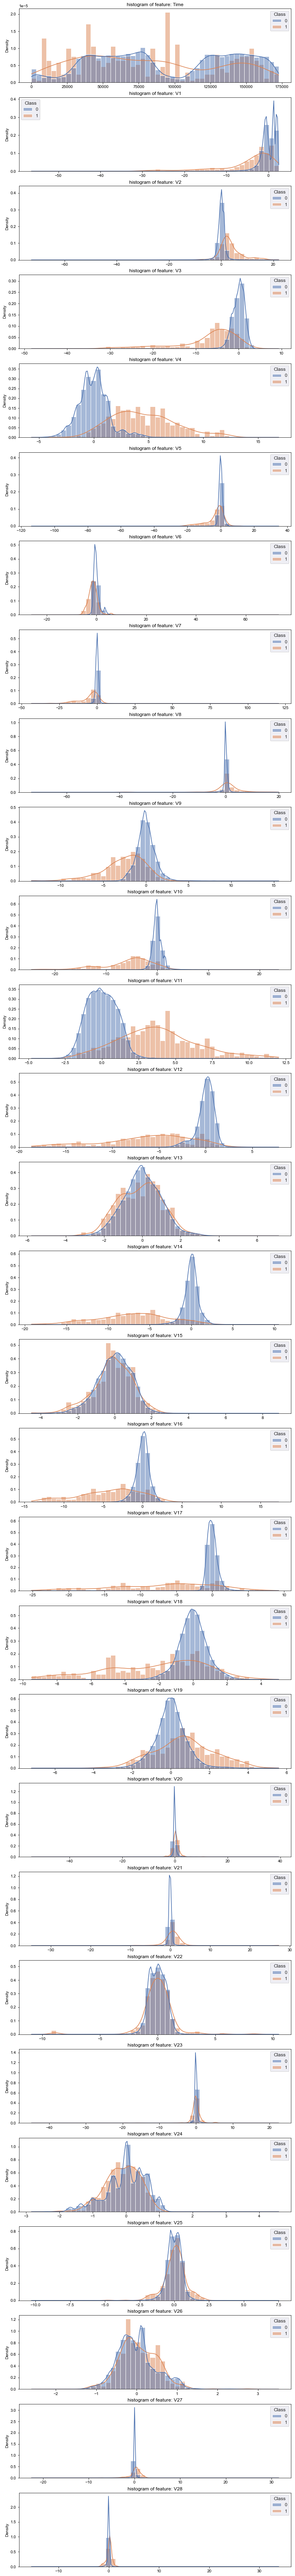

In [6]:
# Plot histograms of features
# Labels: https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot/31632745
# Seaborn cheat_sheet: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Seaborn_Cheat_Sheet.pdf
# Seaborn accepted data structers: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Seaborn_Cheat_Sheet.pdf
fig, axs = plt.subplots(29,1,figsize=(12,29*4))

for i, c in enumerate(df[features]):
    sns.set_theme()
    p1 = sns.histplot(data = df,ax = axs[i], x=df[c],
                 hue = "Class", alpha = 0.5, stat = "density",
                 bins=50, common_norm=False, kde=True
                )
    p1.set_title('histogram of feature: ' + str(c))
    p1.set(xlabel='')
    
plt.show()

In [7]:
# Split Data into fraudulent and legitimate
df_fraud = df[df.Class == 1]
df_legit = df[df.Class == 0]
# df.head()

outlier_fraction = len(df_fraud)/float(len(df_legit))
print(outlier_fraction)
print('Fraud cases: {}'.format(len(df_fraud)))
print('Valid Transaction: {}'.format(len(df_legit)))



0.0017304750013189597
Fraud cases: 492
Valid Transaction: 284315


In [8]:
print("\n\n Amount details of fraudulent transaction")
df_fraud.Amount.describe()



 Amount details of fraudulent transaction


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
print("\n\n Details of valid transaction")
df_legit.Amount.describe()



 Details of valid transaction


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

From the comparison above, it can be seen that average fraudulant transaction has higher value than valid tranasction 122.2 > 88.3
<br>

Lets see correlation between different factors:

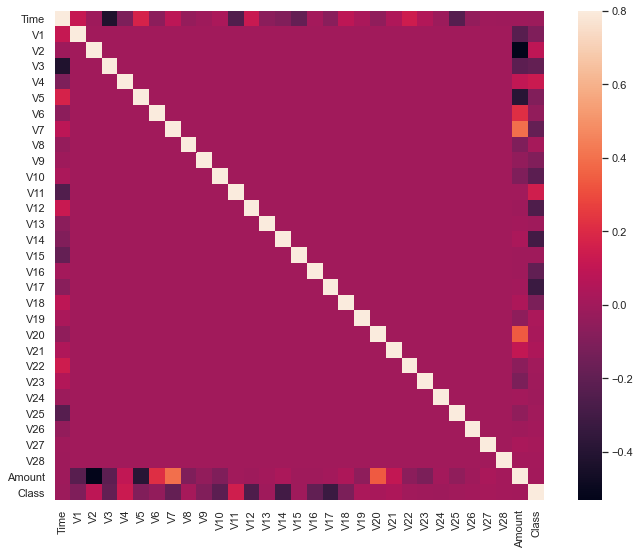

In [10]:
# Correlation matrix
corrmat = df.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In the HeatMap we can clearly see that most of the features do not correlate to other features but there are some features that has positive or a negative correlation with each other: 
<ul>
    <li>V2 and V5 highly negativelly correlate with the Amount</li>
    <li>V20 correlate well with amount</li>
</ul>


In [11]:
# dividing the X and the Y from the dataset
X = df.drop(['Class'], axis = 1)
Y = df['Class']
print(X.shape)
print(Y.shape)
# getting just the values for the sake of processing (its a numpy array with no columns)
X_data = X.values
Y_data = Y.values

(284807, 30)
(284807,)


In [12]:
# Split data into traning and testing set:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 42)
# test_size moves 20% to tasting data
# random_state = 42 This value sets a seed for random alocator of data to test sample.
# In other words, random is not really random.

<h2> Building the Isolation Forest Model</h2>
Isolation forest is generally used for Anomaly detection.  <br>
Often used in:
<ul>
    <li>Predictive maintance</li>
    <li>Network security</li>
    <li>Health care</li>
    <li><u>Finance - Fraud detection</u></li>
</ul>

Advantages of trees:
<ul>
    <li>Interpretable (Is to understand based on what they classifying data)</li>
    <li>Scalable</li>
    <li>Expressive</li>
</ul>

Isolation tree works by spliting data into uniform intervals unitl we get single data point in one of the invertvals.
Isolation trees are great for tabular data with anomalies

In [13]:
# Builidng model/classifier ISOLATION FOREST
from sklearn.ensemble import IsolationForest
ifc=IsolationForest(max_samples=len(X_train),
                   contamination=outlier_fraction, random_state=1)
ifc.fit(X_train)
scores_pred = ifc.decision_function(X_train)
y_pred = ifc.predict(X_test)

In [14]:
# Reshapre the prediction values to 0 for valid, 1 for fraud.
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

n_errors = (y_pred != Y_test).sum

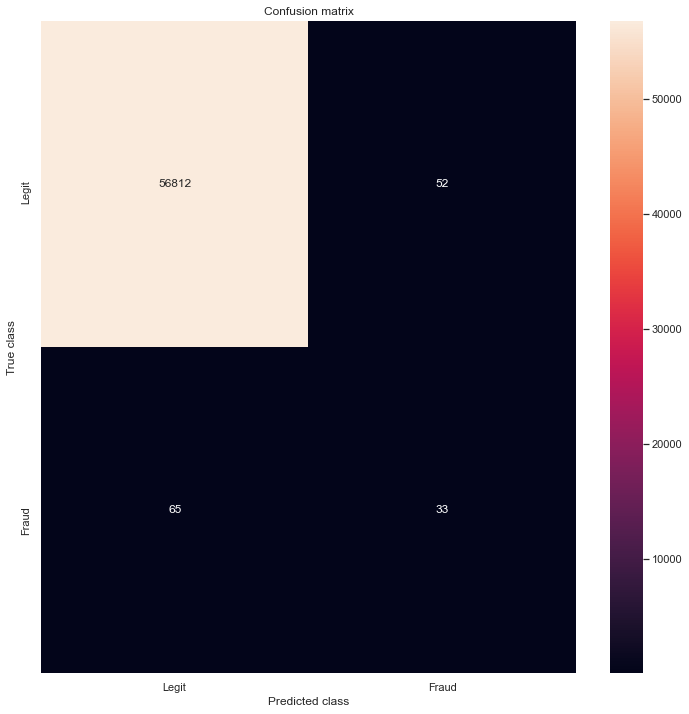

In [15]:
# Visualizing the Confusion Matrix for this model.
# print the confusion matrix
from sklearn.metrics import confusion_matrix
LABELS = ['Legit', 'Fraud']
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

In [16]:
# evaluation of the model
# printing every score of the classifier
# scoring in any thing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
n_outliers = len(df_fraud)
print("the Model used is {}".format("Isolation Forest"))
acc=accuracy_score(Y_test, y_pred)
print("The accuracy is {}".format(acc))
prec=precision_score(Y_test, y_pred)
print("The precision is {}".format(prec))
rec= recall_score(Y_test,y_pred)
print("The recall is {}".format(rec))
f1= f1_score(Y_test,y_pred)
print("The F1-Score is {}".format(f1))
MCC=matthews_corrcoef(Y_test,y_pred)
print("The Matthews correlation coefficient is {}".format(MCC))

the Model used is Isolation Forest
The accuracy is 0.9979459990871107
The precision is 0.38823529411764707
The recall is 0.336734693877551
The F1-Score is 0.36065573770491804
The Matthews correlation coefficient is 0.3605460930519415


<a href="https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall">Accuracy/Precision Source</a><br>
<strong>Accuracy</strong> = (Number of correct predictions)/(Total number of predictions)
<hr>
<strong>Precision</strong> attempts to answer the question: What proportion of positive identifications was actually correct?<br>
Precision = (Number of True Positives)/ ((Number of true postivies)+(Number of false positives)) <br>
Note: a model that produces no false postives has a precision of 1.0
<hr>
<strong>Recall</strong> attempts to answer the question: What proportion of actuall positives was identified correctly?<br>
Recall = (Number of True Positives) / ((Number of True Positives) + (Number of False Negatives)) <br>
Note: A model that produces no false negatives has a recall of 1.0
<hr>
<strong>F-score or F1-score</strong> is a measure of a model's accuracy on a dataset. It is used to evaluate binary classificantion systems, which classify examples into <strong>positive</strong> or <strong>negative</strong>. <br>
The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall. <br>
The F-score is acommonly used for evaulating information retrieval systems such as search engines, and also for many kinds of machine learning models, in particular in natural language processing.

F1 = 2/((1/recall)*(1/precision)) <br>
<a href="https://deepai.org/machine-learning-glossary-and-terms/f-score#:~:text=The%20F%2Dscore%2C%20also%20called,model's%20accuracy%20on%20a%20dataset.&text=The%20F%2Dscore%20is%20a,the%20model's%20precision%20and%20recall.">Source of info</a>
<hr>
<strong>Matthews correlation coefficient</strong> The coefficient takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. <br>
he MCC is in essence a correlation coefficient between the observed and predicted binary classifications; it returns a value between −1 and +1. A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation. However, if MCC equals neither −1, 0, or +1, it is not a reliable indicator of how similar a predictor is to random guessing.

<h2> Building the Random Forest Model</h2>
<br>
Often used in:
<ol>
 <li>Banking Industry</li>
    <ol style="list-style-type: lower-alpha; padding-bottom: 0;">
        <li style="margin-left:2em">Credit Card Fraud Detection</li>
        <li style="margin-left:2em">Customer Segmentation</li>
        <li style="margin-left:2em">Predicting Loan Defaults on LendingClub.com</li>
    </ol>
 <li>Healthcare and Medicine
     <ol style="list-style-type: lower-alpha; padding-bottom: 0;">
         <li style="margin-left:2em">Cardiovascular Disease Prediction</li>
         <li style="margin-left:2em; padding-bottom: 0;">Diabetes Prediction</li>
         <li style="margin-left:2em; padding-bottom: 0;">Breast Cancer Prediction</li>
     </ol>
 </li>
 <li>Stock Market</li>
     <ol style="list-style-type: lower-alpha; padding-bottom: 0;">
         <li style="margin-left:2em">Stock Market Prediction</li>
         <li style="margin-left:2em; padding-bottom: 0;">Stock Market Sentiment Analysis</li>
         <li style="margin-left:2em; padding-bottom: 0;">Bitcoin Price Detection</li>
     </ol>
 <li>E-Commerce</li>
     <ol style="list-style-type: lower-alpha; padding-bottom: 0;">
         <li style="margin-left:2em">Product Recommendation</li>
         <li style="margin-left:2em; padding-bottom: 0;">Price Optimization</li>
         <li style="margin-left:2em; padding-bottom: 0;">Search Ranking</li>
     </ol>
</ol>

Great detailed description of applications of Random Forest Algorithm can be described <a href="https://iq.opengenus.org/applications-of-random-forest/">here</a>

Advantages of trees:
<ul>
    <li>Random forest algorithm is suitable for both classifications and regression task</li>
    <li>It gives higher accuracy through cross validation</li>
    <li>Random forest classifier can handle the missing values and maintain the accuracy of a large proportion of data</li>
    <li>If there are more trees, it doesn't allow over-fitting trees in the model</li>
    <li>It has abilitiy to work upon a large data set with higher dimensionality</li>
</ul>



In [17]:
# Building the Random Forest Classifier (RANDOM FOREST)
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,Y_train)
# predictions
y_pred = rfc.predict(X_test)

In [18]:
# Evaluating the classifier
# Print every score of the classifier
# Scoring in any thing
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
n_outliers = len(df_fraud)
n_errors = (y_pred != Y_test).sum()
print("The model used in Random Forest classifier")
acc = accuracy_score(Y_test, y_pred)
print("The accuracy is {}".format(acc))
prec = precision_score(Y_test, y_pred)
print("The precision is {}".format(prec))
rec = recall_score(Y_test, y_pred)
print("The recall is {}".format(rec))
f1 = f1_score(Y_test, y_pred)
print("The F1-Score is {}".format(f1))
MCC = matthews_corrcoef(Y_test, y_pred)
print("The Matthews correlation coefficientis {}".format(MCC))

The model used in Random Forest classifier
The accuracy is 0.9995611109160493
The precision is 0.974025974025974
The recall is 0.7653061224489796
The F1-Score is 0.8571428571428571
The Matthews correlation coefficientis 0.8631826952924256


<a href="https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall">Accuracy/Precision Source</a><br>
<strong>Accuracy</strong> = (Number of correct predictions)/(Total number of predictions)
<hr>
<strong>Precision</strong> attempts to answer the question: What proportion of positive identifications was actually correct?<br>
Precision = (Number of True Positives)/ ((Number of true postivies)+(Number of false positives)) <br>
Note: a model that produces no false postives has a precision of 1.0
<hr>
<strong>Recall</strong> attempts to answer the question: What proportion of actuall positives was identified correctly?<br>
Recall = (Number of True Positives) / ((Number of True Positives) + (Number of False Negatives)) <br>
Note: A model that produces no false negatives has a recall of 1.0
<hr>
<strong>F-score or F1-score</strong> is a measure of a model's accuracy on a dataset. It is used to evaluate binary classificantion systems, which classify examples into <strong>positive</strong> or <strong>negative</strong>. <br>
The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall. <br>
The F-score is acommonly used for evaulating information retrieval systems such as search engines, and also for many kinds of machine learning models, in particular in natural language processing.

F1 = 2/((1/recall)*(1/precision)) <br>
<a href="https://deepai.org/machine-learning-glossary-and-terms/f-score#:~:text=The%20F%2Dscore%2C%20also%20called,model's%20accuracy%20on%20a%20dataset.&text=The%20F%2Dscore%20is%20a,the%20model's%20precision%20and%20recall.">Source of info</a>
<hr>
<strong>Matthews correlation coefficient</strong> The coefficient takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. <br>
he MCC is in essence a correlation coefficient between the observed and predicted binary classifications; it returns a value between −1 and +1. A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation. However, if MCC equals neither −1, 0, or +1, it is not a reliable indicator of how similar a predictor is to random guessing.

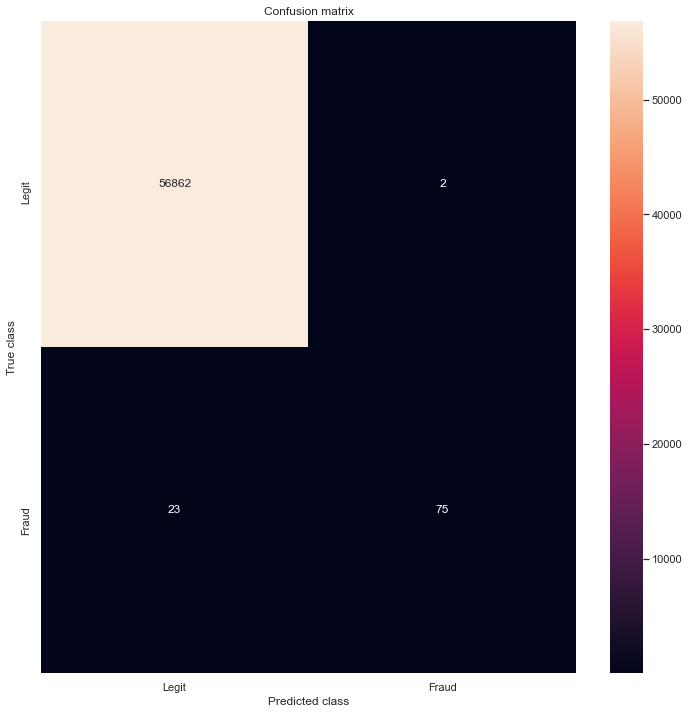

In [19]:
# Visualizing the Confusion Matrix for Random Forests.
# print the confusion matrix
from sklearn.metrics import confusion_matrix
LABELS = ['Legit', 'Fraud']
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

<h2>Visualizing the Forest</h2>
    It is useful to visualise a randomly selected single tree fo the sake of knowning how the Algorithm is taking its decision and this will help in changing the model easily if a coutnermeasure is taken by the scammers.

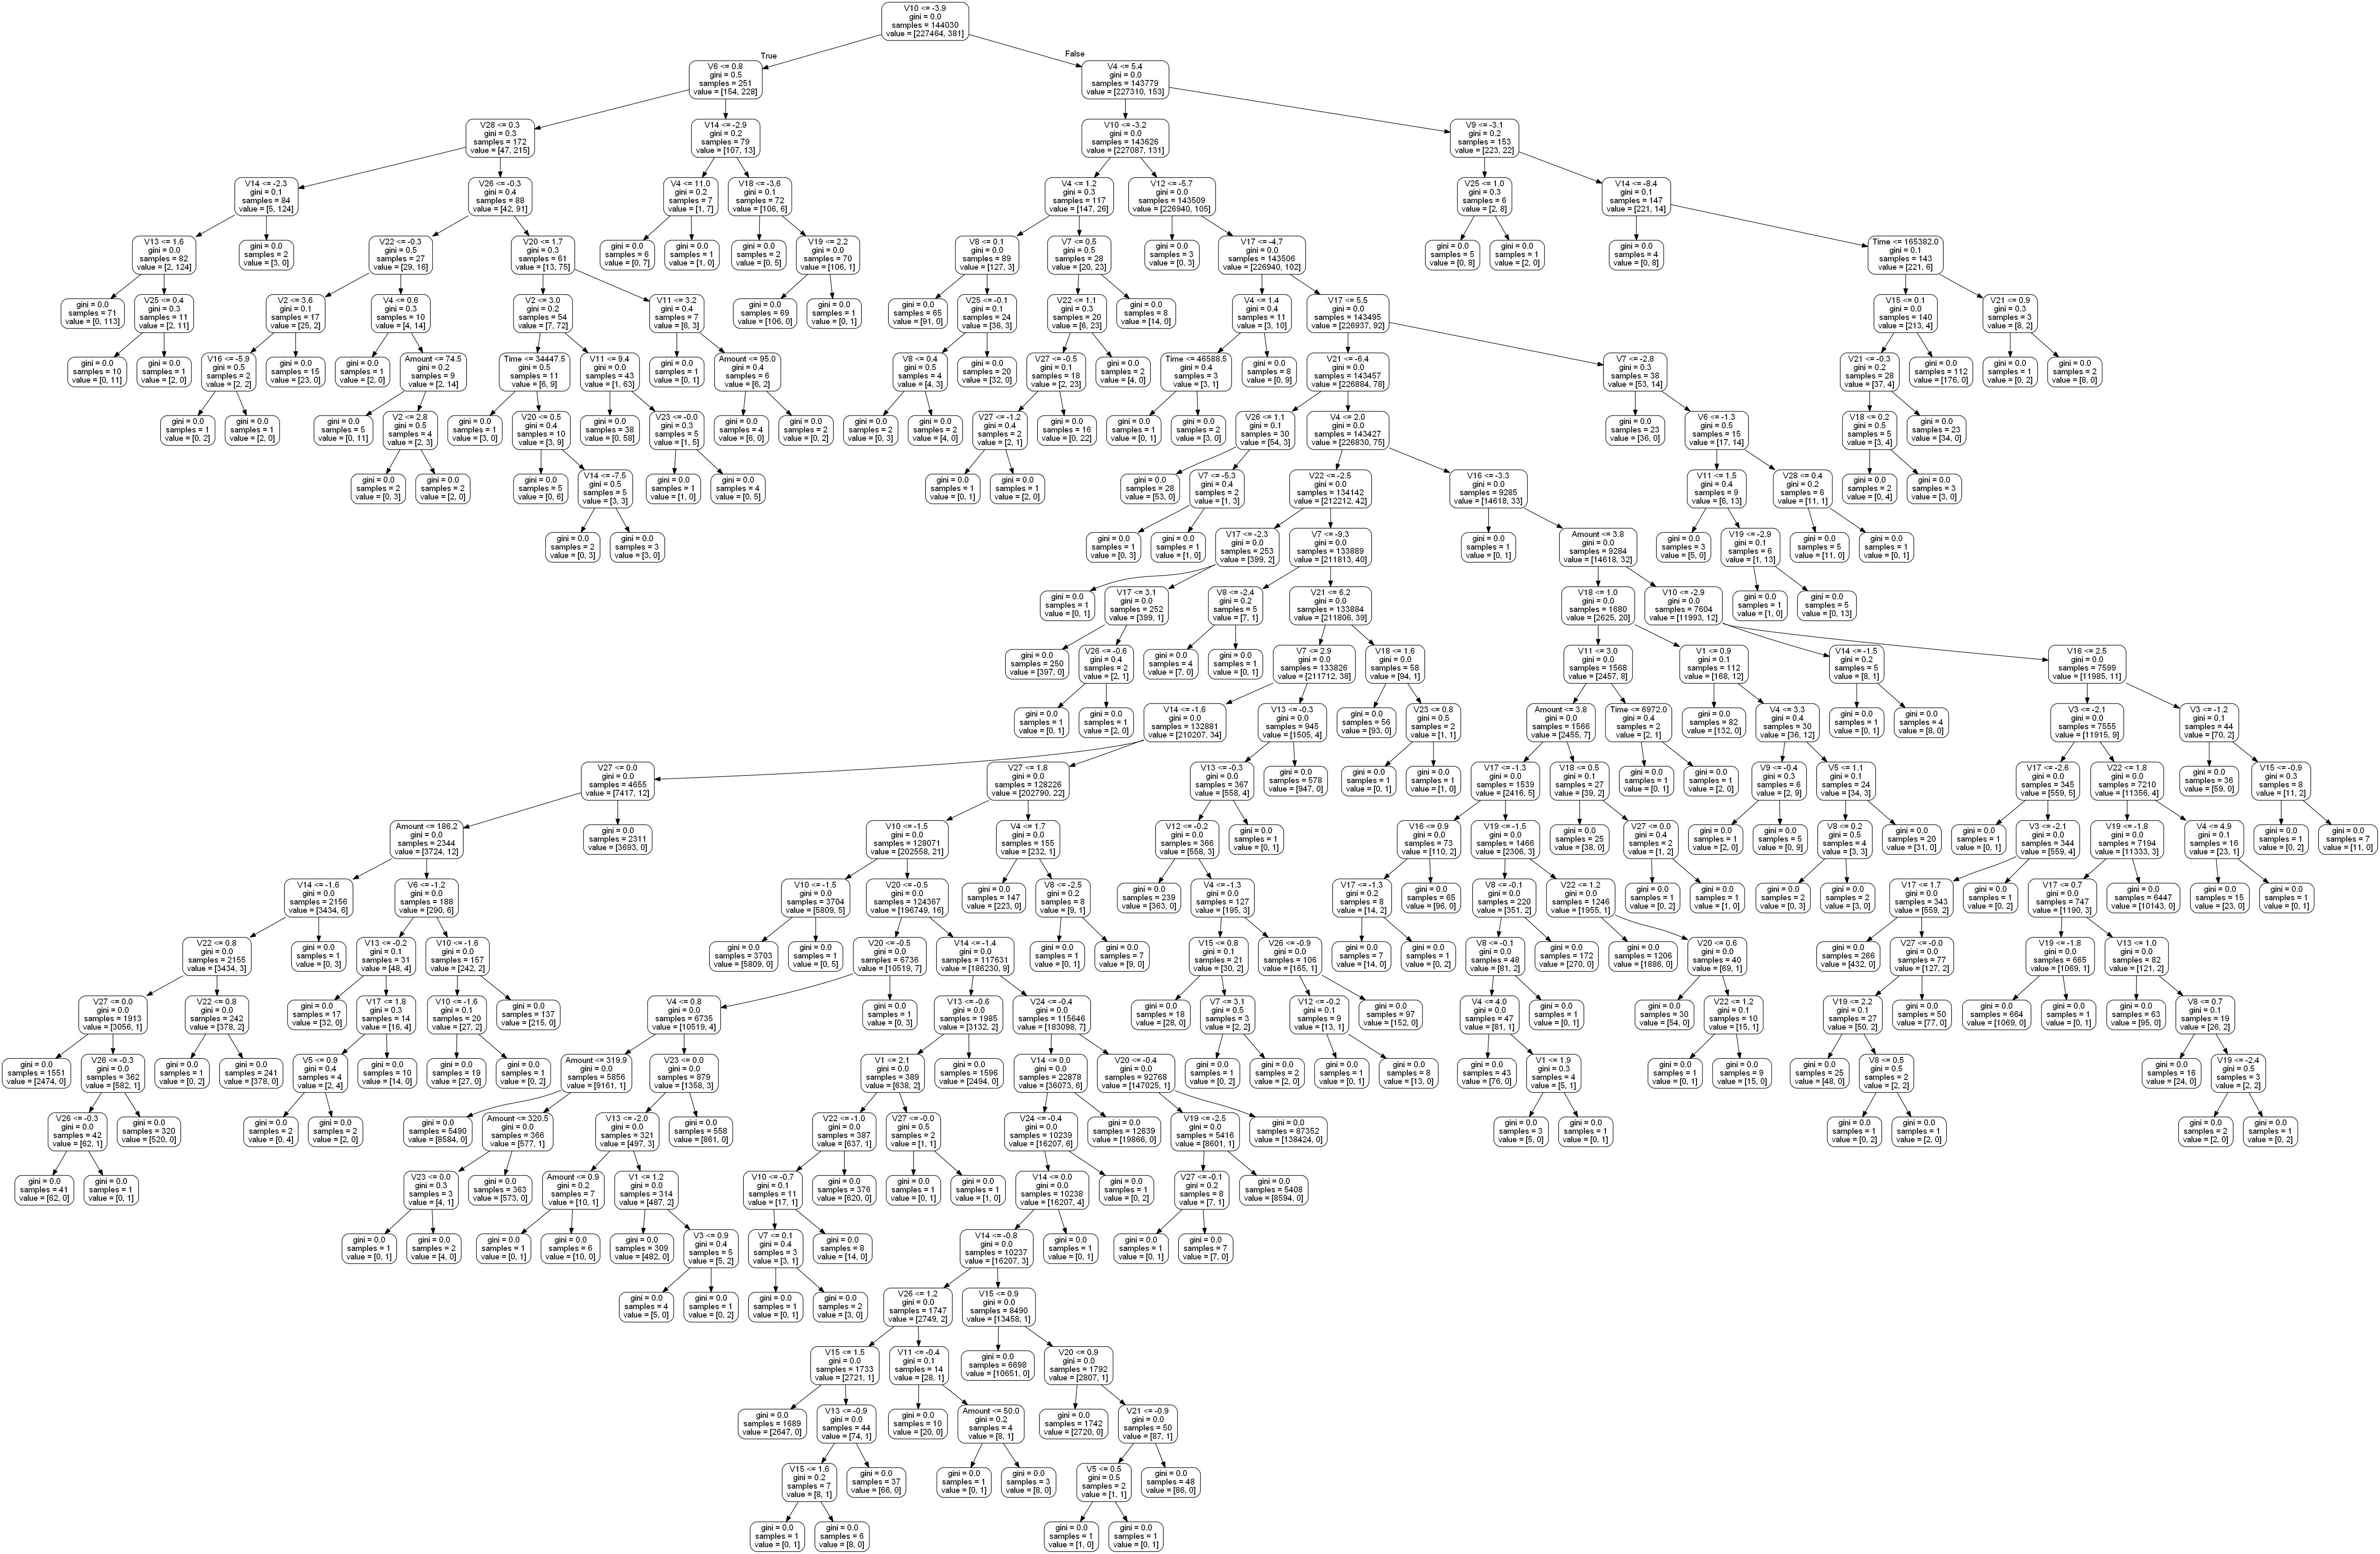

In [20]:
# visualizing the random tree
feature_list = list(X.columns)
# Import tools needed for visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot

# pulling out one tree from the forest
tree = rfc.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
display(Image(graph.create_png()))

<h2> Building Logistic Regresion Model</h2>
<a href="https://songhuiming.github.io/pages/2018/05/05/credit-card-fraud-detection-imbalanced-data-modeling-part-i-logistic-regression/">Fraud Detection using Logistic Regression</a>

<br>
Often used in:
<ol>
    <li><strong>Credit Score</strong> - ID Finance is a financial company that makes predictive models for credit scoring. They need their models to be easily interpretable. They can be asked by a regulator about a certain decision at any moment.

Data preprocessing for credit scoring modeling includes such a step like reducing correlated variables. It’s difficult if you have more than 15 variables in your model. For logistic regression, it is easy to find out which variables affect the final result of the predictions more and which ones less. It is also possible to find the optimal number of features and eliminate redundant variables with methods like recursive feature elimination.

At the final step, they can export prediction results to an Excel file, and analytic even without technical skills can get insights from this data. 

At some point, ID finance refused the use of third-party statistical applications and rewrote their algorithms for building models in Python. This has led to a significant increase in the speed of model development. But they did not abandon logistic regression in favor of more complex algorithms. Logistic regression is widely used in credit scoring and it shows remarkable results.</li><br>

 <li><strong>Medicine</strong> - Medical information is gathered in such a way that when a research group studies a biological molecule and its properties, they publish a paper about it. Thus, there is a huge amount of medical data about various compounds, but they are not combined into a single database.

Miroculus is a company that develops express blood test kits. Its goal is to identify diseases that are affected by genes, such as oncology diseases. The company entered into an agreement with Microsoft to develop an algorithm to identify the relationship between certain micro-RNA and genes.

The developers used a database of scientific articles and applied text analysis methods to obtain feature vectors. The text was split into the sentences, the entities were extracted, labeled data generated from known relations, and after several other text transformation methods, each sentence was converted into a 200-dimensional vector.

After converting the text and extracting the distinguishing features, a classification was made for the presence of a link between microRNA and a certain gene. Algorithms such as logistic regression, support vector machine, and random forest were considered as models. Logistic regression was selected because it demonstrated the best results in speed and accuracy.

Logistic regression is well suited for this data type when we need to predict a binary answer. Is there a connection between the elements or not? Thanks to this algorithm, the accuracy of a quick blood test have been increased.</li><br>
    
<li><strong>Text Editing</strong> - As we talked about texts, it is worth mentioning that logistic regression is a popular choice in many natural language processing tasks. First, the text preprocessing is performed, then features are extracted, and finally, logistic regression is used to make some claim about a text fragment. Toxic speech detection, topic classification for questions to support, and email sorting are examples where logistic regression shows good results. Other popular algorithms for making a decision in these fields are support vector machines and random forest.

Let's look at the less popular NLP task - text transformation or digitalization. One company has faced this problem: they had a lot of PDF text files and texts extracted from scans with the OCR system. Such files had a fixed structure with line break by the characters of the end of the paragraph, and with hyphens. They needed to transform this data into usable text with grammatical and semantic correct formatting.

The developer manually marked out three large documents, adding special characters to the beginning of the line indicating whether it should be glued to the previous line. As features were chosen: the length of the current and previous lines in characters, the average length of several lines around, whether the last character of the previous line is a letter or a digit, punctuation mark on which the previous line ends, and some other properties. All string and boolean features were transformed into numerical. Then logistic regression was trained.

It showed a few errors and these were mainly the same errors that humans can make in such a situation. There were very few easy human-readable errors. Logistic regression showed excellent results in this task, and a lot of texts were automatically transformed using this method.</li><br>

 <li><strong>Hotel Booking</strong> - Booking.com has a lot of machine learning methods literally everywhere on the site. They try to predict users' intentions and recognize entities. Where will you go, where do you prefer to stop, what are you planning to do? Some predictions are made even if the user didn't type anything in the search line yet. But how did they start to do this? No one can build a huge and complex system with various machine learning algorithms from scratch. They have accumulated some statistics and created some simple models as the first steps.

Most of the features at such services like booking.com are rather categorical than numerical. Sometimes it becomes necessary to predict an event without specific data about the user. For example, all the data they have is where the user is from and where she wants to go. Logistic regression is ideal for such needs.

Here is a histogram of logistic regression trying to predict either user will change a journey date or not. It was presented at HighLoad++ Siberia conference in 2018. <img src="https://lh3.googleusercontent.com/pu0o4MO_EzuXTNuRyVZ8QRNR8RvX0vNs76qmhF0BivuDLYXCm3HhC2XXZZyzTQ3f2Jr9lq9T080fj9HDp3ZJwX7iWdC6AAFi-Wkliay28oFJ95GkETiKiCWMP4ovsifch9xlhdfw" alt="image info" />
</li><br>

<li><strong>Gaming</strong> - Speed is one of the advantages of logistic regression, and it is extremely useful in the gaming industry. Speed is very important in a game. Very popular today are the games where you can use in-game purchases to improve the gaming qualities of your character, or for fancy appearance and communication with other players. In-game purchases are a good place to introduce a recommendation system. 
Tencent is the world's largest gaming company. It uses such systems to suggest gamers' equipment which they would like to buy. Their algorithm analyzes a very large amount of data about user behavior and gives suggestions about equipment a particular user may want to acquire on the run. This algorithm is logistic regression.
There are three types of recommendation systems. The collaborative system predicts what the user would like to buy based on ratings from users with similar preferences in previous purchases, and other activity. A content-based algorithm makes its decision based on properties specified in the item description and what the user indicated as interests in her profile. The third type is the hybrid and it is a combination of two previous types.

Both the description and the preferences of other users can be used as features in logistic regression. You only need to transform them into a similar format and normalize. Logistic regression will work fast and show good results. </li>
<br>
<hr>
Great detailed description of Advantages and Disadvantages of Logistic Regression <a href="https://iq.opengenus.org/advantages-and-disadvantages-of-logistic-regression/">here</a>

Advantages of trees:
<ul>
    <li>one of the simplest machine learning algorithms</li>
    <li>The predicted parameters (trained weights) give inference about the importance of each feature</li>
    <li>This algorithm allows models to be updated easily to reflect new data</li>
    <li>Logistic Regression outputs well-calibrated probabilities along with classification results.</li>
    <li>In a low dimensional dataset having a sufficient number of training examples, logistic regression is less prone to over-fitting</li>
    <li>Rather than straight away starting with a complex model, logistic regression is sometimes used as a benchmark model to measure performance, as it is relatively quick and easy to implement</li>
    <li>Logistic Regression proves to be very efficient when the dataset has features that are linearly separable</li>
    <li>This algorithm can easily be extended to multi-class classification using a softmax classifier, this is known as Multinomial Logistic Regression.</li>
    <li>Resultant weights found after training of the logistic regression model, are found to be highly interpretable. The weight w_i can be interpreted as the amount log odds will increase, if x_i increases by 1 and all other x's remain constant. i here refers to any training example from i = 0 to n</li>
</ul>

Logistic regression is one of the classic machine learning methods. It forms a basis of machine learning along with linear regression, k-mean clustering, principal component analysis, and some others. Neural networks were developed on top of logistic regression.

In [21]:
# 1. Split Test Data Out
df_rl = df.copy()
df_rl.drop(columns = 'Time', inplace = True)

# Normalize the 'amount' column ( Basically it is a scaling techinque wherein it makes data scale-free by 
# converting the statistical distribution of the data into the mean = 0 and standard deviation =1)
# Note: that Standardization is only applicable on the data values that follows Normal Distribution
# More on normalization here: https://www.journaldev.com/45025/standardscaler-function-in-python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_rl['Amount'] = scaler.fit_transform(df_rl['Amount'].values.reshape(-1,1))

x = df_rl.iloc[:, :-1]
y = df_rl.iloc[:, -1]
seed = 999

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = .33, stratify = y, random_state = seed)

<h3>Logistic Regresion - Model imbalanced data directly</h3>

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logitreg_parameters = {'C': np.power(10.0, np.arange(-3, 3))}
logitreg = LogisticRegression(verbose = 3, warm_start = True)
logitreg_grid = GridSearchCV(logitreg, param_grid = logitreg_parameters, scoring = 'roc_auc', n_jobs = -1)
logitreg_grid.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


GridSearchCV(estimator=LogisticRegression(verbose=3, warm_start=True),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='roc_auc')

In [48]:
print("The model Logistic Regresion with imbalanced data directly")
acc = accuracy_score(ytest, logitreg_grid.predict(xtest))
print("The accuracy is {}".format(acc))
prec = precision_score(ytest, logitreg_grid.predict(xtest))
print("The precision is {}".format(prec))
rec = recall_score(ytest, logitreg_grid.predict(xtest))
print("The recall is {}".format(rec))
f1 = f1_score(ytest, logitreg_grid.predict(xtest))
print("The F1-Score is {}".format(f1))
MCC = matthews_corrcoef(ytest, logitreg_grid.predict(xtest))
print("The Matthews correlation coefficientis {}".format(MCC))

The model Logistic Regresion with imbalanced data directly
The accuracy is 0.9989785821443391
The precision is 0.851063829787234
The recall is 0.49382716049382713
The F1-Score is 0.625
The Matthews correlation coefficientis 0.6478582390108228


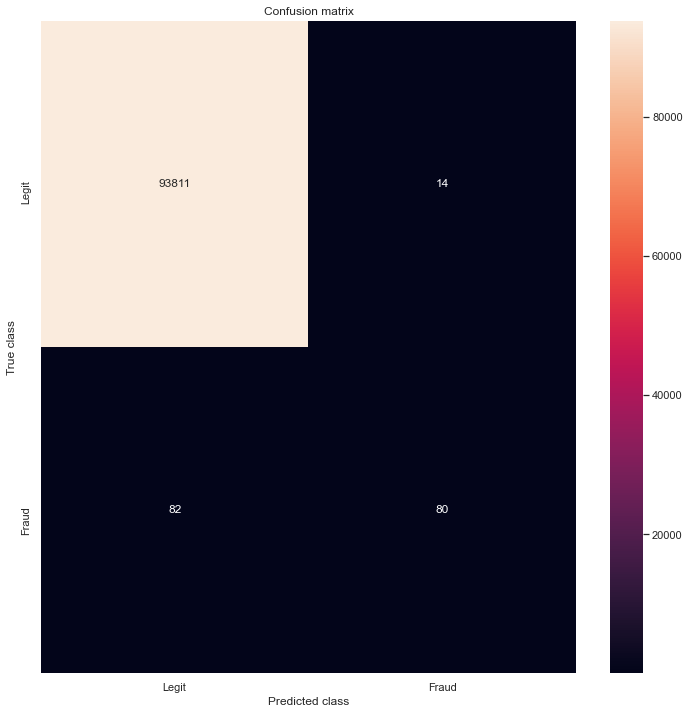

In [47]:
LABELS = ['Legit', 'Fraud']
conf_matrix = confusion_matrix(ytest, logitreg_grid.predict(xtest))
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

<h3>Change the Thresholds</h3>

In [34]:
from sklearn.metrics import roc_curve
ytrain_pred_probas = logitreg_grid.predict_proba(xtrain)[:, 1]
fpr, tpr, thresholds = roc_curve(ytrain, ytrain_pred_probas)
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

Text(0, 0.5, 'TPR')

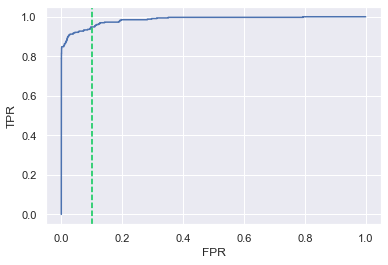

In [38]:
_ = plt.figure()
plt.plot(roc.FPR, roc.TPR)
plt.axvline(0.1, color = '#00C851', linestyle = '--')
plt.xlabel("FPR")
plt.ylabel("TPR")

By default, the threshold is 0.5. Since the recall score is low, we shall lower the threshold to get more predicted as Positive. At the same time, more True Negative data will be falsely predicted as Positive. So the Precision score will be lower.

In [40]:
ytest_pred_probas = logitreg_grid.predict_proba(xtest)[:, 1]
new_threshold = 0.1   # 0.5 is the default value
ytest_pred = (ytest_pred_probas >= new_threshold).astype(int)

In [44]:
print("The model Logistic Regresion with imbalanced data directly with lowered threshold from 0.5 to 0.1")
acc = accuracy_score(ytest, ytest_pred)
print("The accuracy is {}".format(acc))
prec = precision_score(ytest, ytest_pred)
print("The precision is {}".format(prec))
rec = recall_score(ytest, ytest_pred)
print("The recall is {}".format(rec))
f1 = f1_score(ytest, ytest_pred)
print("The F1-Score is {}".format(f1))
MCC = matthews_corrcoef(ytest, ytest_pred)
print("The Matthews correlation coefficientis {}".format(MCC))

The model Logistic Regresion with imbalanced data directly with lowered threshold from 0.5 to 0.1
The accuracy is 0.9992339366082543
The precision is 0.8571428571428571
The recall is 0.6666666666666666
The F1-Score is 0.75
The Matthews correlation coefficientis 0.7555664736097949


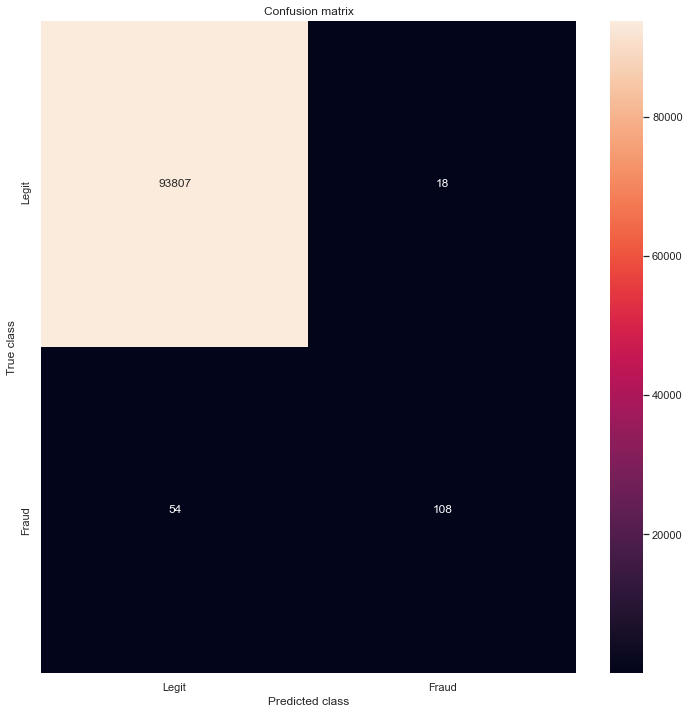

In [45]:
LABELS = ['Legit', 'Fraud']
conf_matrix = confusion_matrix(ytest, ytest_pred)
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()